In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from importlib import reload
import wrapper
from wrapper.models.bubble import BubbleBurster
from trecs.components import Users
from src.utils import get_topic_clusters
from sklearn.decomposition import NMF
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics
import os
import src
import trecs
from trecs.models import ContentFiltering
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement

random_state = np.random.seed(42)

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
ratings_df = pd.read_csv('data/ml-100k/u.data', sep="\t", names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

## Creating RecommenderSystem on MovieLens 

### Creating Embeddings

In [4]:
from sklearn.decomposition import NMF

binary_ratings_df = ratings_df.drop(columns=['Timestamp'])
binary_ratings_df.loc[binary_ratings_df['Rating'] > 0, 'Rating'] = 1

# turn dataframe into matrix where each movie is a column and each user is a row
binary_ratings_matrix = binary_ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0).to_numpy()

In [5]:
from lightfm.cross_validation import random_train_test_split
from scipy import sparse

# split data into train and test sets
train_interactions, test_interactions = random_train_test_split(sparse.csr_matrix(binary_ratings_matrix), test_percentage=0.2, random_state=random_state)
train_interactions = train_interactions.toarray()
test_interactions = test_interactions.toarray()

c:\Users\Jannik\anaconda3\envs\rsenv\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [6]:
n_attrs=100
max_iter=500

if not os.path.exists('artefacts/'):
    os.mkdir('artefacts/')

user_representation_file_path = f'artefacts/ml_user_representations_{max_iter}maxiter.npy'
item_representation_file_path = f'artefacts/ml_item_representations_{max_iter}maxiter.npy'
if not os.path.exists(user_representation_file_path) or not os.path.exists(item_representation_file_path):
    nmf = NMF(n_components=n_attrs, init='random', random_state=random_state, max_iter=max_iter)
    user_representation = nmf.fit_transform(train_interactions)
    item_representation = nmf.components_
    np.save(user_representation_file_path, user_representation)
    np.save(item_representation_file_path, item_representation)
else:
    user_representation = np.load(user_representation_file_path)
    item_representation = np.load(item_representation_file_path)

print(user_representation.shape, item_representation.shape)

(943, 100) (100, 1682)


In [7]:
users = Users(actual_user_profiles=user_representation, repeat_interactions=False, attention_exp=1.5)

## Create Fair RS Model

In [8]:
# Define topic clusters using NMF
max_iter=200
nmf_solver='mu'

topic_clusters_file_path = f'artefacts/ml_topic_clusters_{max_iter}maxiter_{nmf_solver}solver.npy'
if not os.path.exists(topic_clusters_file_path):
    item_topics = get_topic_clusters(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter, nmf_solver=nmf_solver)
    np.save(topic_clusters_file_path, item_topics)
else:
    item_topics = np.load(topic_clusters_file_path)

## Simulation

In [9]:
timesteps=100
user_pairs = [(u_idx, v_idx) for u_idx in range(len(user_representation)) for v_idx in range(len(user_representation))]
measurements_list = [
    InteractionMeasurement(), 
    MSEMeasurement(diagnostics=True), 
    InteractionSpread(), 
    InteractionSimilarity(pairs=user_pairs), 
    RecSimilarity(pairs=user_pairs), 
    # TopicInteractionMeasurement(),
    MeanNumberOfTopics(),
    SerendipityMetric(), 
    DiversityMetric(), 
    NoveltyMetric()
]

In [10]:
def plot_measurements(measurements_df):

    fig, ax = plt.subplots(2, 3, figsize=(15, 6))

    measurements_df['rec_similarity'].plot(ax=ax[0, 0])
    measurements_df['interaction_similarity'].plot(ax=ax[0, 1])
    measurements_df['mean_num_topics'].plot(ax=ax[0, 2])
    measurements_df['serendipity_metric'].plot(ax=ax[1, 0])
    measurements_df['novelty_metric'].plot(ax=ax[1, 1])
    measurements_df['diversity_metric'].plot(ax=ax[1, 2])

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    ax[0, 0].set_title('Recommendation similarity')
    ax[0, 0].set_ylabel('Similarity')
    
    ax[0, 1].set_title('Interaction Similarity')
    ax[0, 1].set_ylabel('Jaccard Similarity')

    ax[0, 2].set_title('Mean Number of Topics per User')
    ax[0, 2].set_ylabel('Mean Number of Topics per User')
    
    ax[1, 0].set_title('Serendipity')
    ax[1, 0].set_ylabel('Serendipity')
    
    ax[1, 1].set_title('Novelty')
    ax[1, 1].set_ylabel('Novelty')

    ax[1, 2].set_title('Diversity')
    ax[1, 2].set_ylabel('Diversity')

    

In [ ]:
def plot_histograms(model, measurements_df):
    # for every 10 timesteps plot line in different color
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(10, timesteps+10, 10):
        ax[0].plot(np.arange(model.num_items), sorted(measurements_df['interaction_histogram'][i]), label=f't={i}')
        ax[1].plot(np.arange(model.num_items), sorted(measurements_df['topic_interaction_histogram'][i]), label=f't={i}')

    ax[0].set_title('Interaction Histogram')
    ax[0].set_xlabel('Items')
    ax[0].set_ylabel('# Interactions')
    ax[0].legend()
    # ax[1].set_title('Topic Interaction Similarity')
    # ax[1].set_xlabel('Topics')
    # ax[1].set_ylabel('# Interactions')
    # ax[1].legend()

### Baseline (myopic)

In [12]:
# Baseline Model
myopic = BubbleBurster(
    item_topics=item_topics,
    actual_item_representation=item_representation,
    actual_user_representation=users,
    num_attributes=n_attrs,
    record_base_state=True,
)

# Add metrics
myopic.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {myopic.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {myopic.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 100)
- A randomly generated matrix of items of dimension (100, 1682)


In [13]:
# user_topic_history_df = pd.DataFrame(myopic.user_topic_history)
# user_topic_history_df['sum'] = user_topic_history_df.sum(axis=0) 
# user_topic_history_df

In [14]:
# Baseline (myopic)
myopic.startup_and_train(timesteps=timesteps)

100%|██████████| 100/100 [41:14<00:00, 24.74s/it]


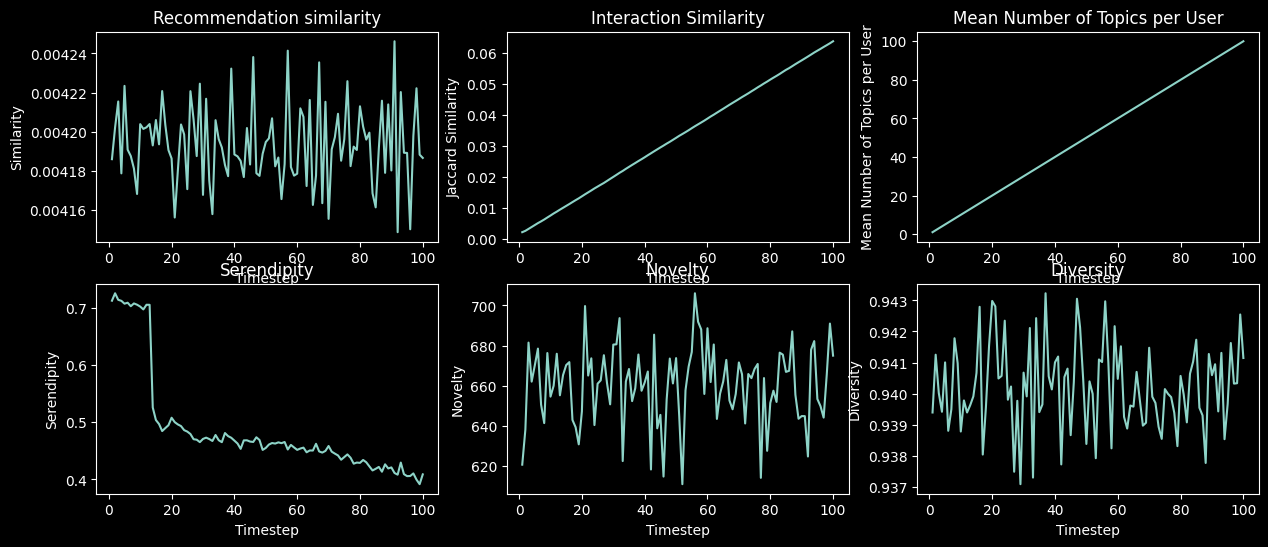

In [15]:
myopic_measurements = myopic.get_measurements()
myopic_measurements_df = pd.DataFrame(myopic_measurements)
myopic_measurements_df.to_csv(f'artefacts/ml_myopic_measurements_{timesteps}timesteps_{max_iter}maxiter_{nmf_solver}solver_{n_attrs}nAttrs.csv')
plot_measurements(myopic_measurements_df)

In [16]:
myopic_measurements_df

,interaction_histogram,mse,interaction_spread,interaction_similarity,rec_similarity,mean_num_topics,serendipity_metric,diversity_metric,novelty_metric,timesteps
0,None,0.036256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,"[0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, ...",0.036256,-939.5,0.002225,0.004186,1.0,0.713150,0.939390,620.616741,1
2,"[2.0, 0.0, 1.0, 3.0, 3.0, 1.0, 3.0, 2.0, 1.0, ...",0.036256,0.5,0.002660,0.004202,2.0,0.726193,0.941251,638.166737,2
3,"[2.0, 1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 1.0, 3.0, ...",0.036256,-1.0,0.003277,0.004215,3.0,0.714740,0.940014,681.463201,3
4,"[0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 1.0, 0.0, ...",0.036256,0.0,0.003900,0.004179,4.0,0.712937,0.939413,662.011386,4
...,...,...,...,...,...,...,...,...,...,...
96,"[2.0, 3.0, 0.0, 1.0, 2.0, 1.0, 4.0, 0.0, 0.0, ...",0.036256,-0.5,0.061446,0.004150,96.0,0.405938,0.941628,649.760047,96
97,"[0.0, 2.0, 2.0, 2.0, 3.0, 0.0, 3.0, 2.0, 0.0, ...",0.036256,1.0,0.062060,0.004198,97.0,0.410498,0.940320,644.069044,97
98,"[1.0, 1.0, 2.0, 3.0, 1.0, 0.0, 0.0, 2.0, 1.0, ...",0.036256,-1.0,0.062650,0.004222,98.0,0.399576,0.940332,665.726317,98
99,"[3.0, 1.0, 0.0, 1.0, 4.0, 1.0, 5.0, 2.0, 0.0, ...",0.036256,0.0,0.063256,0.004188,99.0,0.391622,0.942547,690.950028,99


### Myopic Probabilistic Model

In [17]:
# Myopic Model with probabilistic recommendations
myopic_prob = BubbleBurster(
    probabilistic_recommendations=False,
    item_topics=item_topics,
    actual_item_representation=item_representation,
    actual_user_representation=users,
    num_attributes=n_attrs,
    record_base_state=True,
)

# Add Metrics
myopic_prob.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {myopic.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {myopic.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 100)
- A randomly generated matrix of items of dimension (100, 1682)


In [18]:
# Baseline (myopic)
myopic_prob.startup_and_train(timesteps=timesteps)

100%|██████████| 100/100 [1:51:53<00:00, 67.13s/it]  


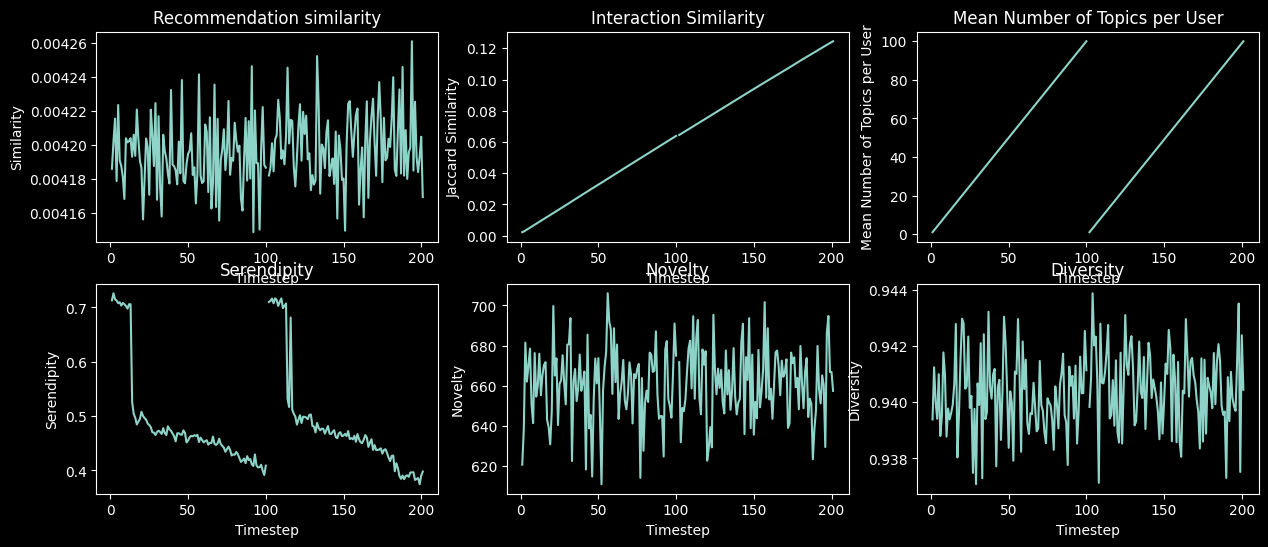

In [19]:
myopic_prob_measurements = myopic.get_measurements()
myopic_prob_measurements_df = pd.DataFrame(myopic_prob_measurements)
myopic_prob_measurements_df.to_csv(f'artefacts/ml_myopic_prob_measurements_{timesteps}timesteps_{max_iter}maxiter_{nmf_solver}solver_{n_attrs}nAttrs.csv')
plot_measurements(myopic_prob_measurements_df)

In [ ]:
del myopic_prob

### Fair Model

In [20]:
import trecs.matrix_ops as mo
import scipy.spatial as sp
from numpy.linalg import norm

def cosine_similarity_reranking(predicted_user_profiles, predicted_item_attributes):
    # Reranking
    alpha = 0.4
    predicted_scores = mo.inner_product(predicted_user_profiles, predicted_item_attributes)
    # create a vector that contains the norms of all row vectors in predicted_user_profiles
    user_norms = norm(predicted_user_profiles, axis=1)
    item_norms = norm(predicted_item_attributes, axis=0)

    # create a matrix that contains the outer product of user_norms and item_norms
    norms = np.outer(user_norms, item_norms)
    cosine_similarities = predicted_scores / norms
    # print max value of norms
    re_ranked_scores = predicted_scores - alpha * cosine_similarities
    return re_ranked_scores

In [21]:
# Fair Model
fairsys = BubbleBurster(
    item_topics=item_topics,
    actual_item_representation=item_representation,
    num_attributes=n_attrs,
    actual_user_representation=users,
    record_base_state=True,
    score_fn=cosine_similarity_reranking,
)

fairsys.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {myopic.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {myopic.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 100)
- A randomly generated matrix of items of dimension (100, 1682)


c:\Users\Jannik\anaconda3\envs\rsenv\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [22]:
# Fair Model
fairsys.startup_and_train(timesteps=timesteps)

100%|██████████| 100/100 [2:30:10<00:00, 90.11s/it]  


interaction_histogram 303
mse 303
interaction_spread 303
interaction_similarity 303
rec_similarity 303
mean_num_topics 303
serendipity_metric 303
diversity_metric 303
novelty_metric 303
timesteps 303


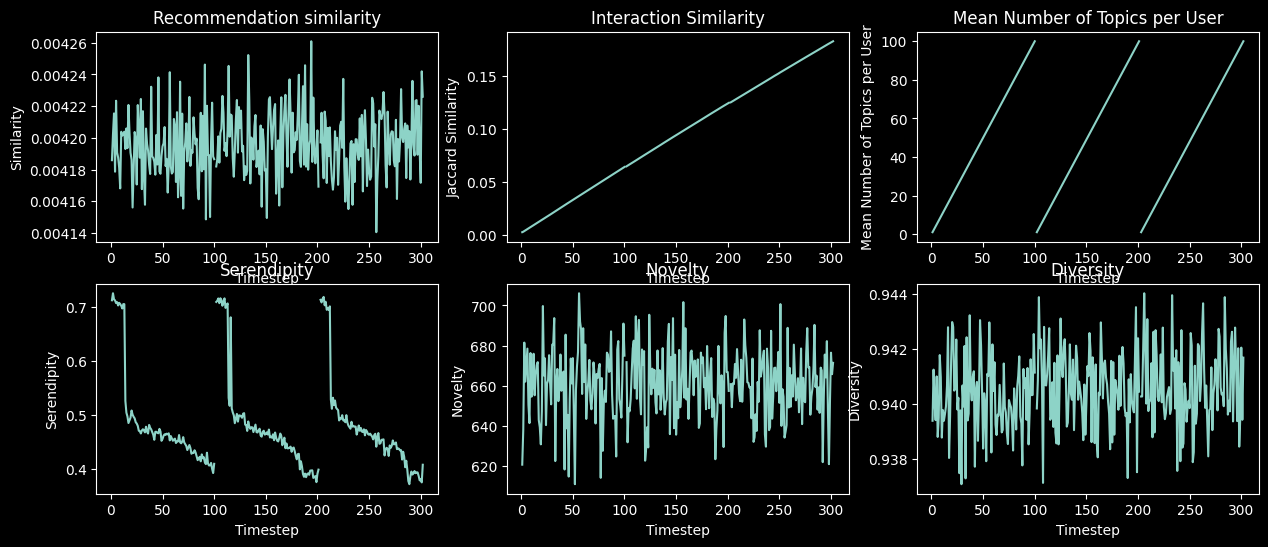

In [35]:
fairsys_measurements = fairsys.get_measurements()
for key, values in fairsys_measurements.items():
    print(key, len(values))
fairsys_measurements_df = pd.DataFrame(fairsys_measurements)
fairsys_measurements_df.to_csv(f'artefacts/ml_fairsys_measurements_{timesteps}timesteps_{max_iter}maxiter_{nmf_solver}solver_{n_attrs}nAttrs.csv')
plot_measurements(fairsys_measurements_df)

In [44]:
df = fairsys_measurements_df.copy()
# add column named model
df['model'] = 'fairsys'
# for the first 100 entries make model column equal myopic
df.loc[:100, 'model'] = 'myopic'
df.loc[101:201, 'model'] = 'myopic_prob'
# change values between 101 and 201 to 0 to 100
df.loc[101:201, 'timesteps'] = df.loc[101:201, 'timesteps'] -101
df.loc[202:302, 'timesteps'] = df.loc[202:302, 'timesteps'] -202

df

,interaction_histogram,mse,interaction_spread,interaction_similarity,rec_similarity,mean_num_topics,serendipity_metric,diversity_metric,novelty_metric,timesteps,model
0,None,0.036256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,myopic
1,"[0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, ...",0.036256,-939.5,0.002225,0.004186,1.0,0.713150,0.939390,620.616741,1,myopic
2,"[2.0, 0.0, 1.0, 3.0, 3.0, 1.0, 3.0, 2.0, 1.0, ...",0.036256,0.5,0.002660,0.004202,2.0,0.726193,0.941251,638.166737,2,myopic
3,"[2.0, 1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 1.0, 3.0, ...",0.036256,-1.0,0.003277,0.004215,3.0,0.714740,0.940014,681.463201,3,myopic
4,"[0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 1.0, 0.0, ...",0.036256,0.0,0.003900,0.004179,4.0,0.712937,0.939413,662.011386,4,myopic
...,...,...,...,...,...,...,...,...,...,...,...
298,"[0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...",NaN,0.0,0.180559,0.004220,96.0,0.386320,0.938447,620.874007,96,fairsys
299,"[0.0, 1.0, 4.0, 0.0, 2.0, 1.0, 3.0, 1.0, 2.0, ...",NaN,0.0,0.181117,0.004191,97.0,0.378049,0.939496,652.329993,97,fairsys
300,"[0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, ...",NaN,0.0,0.181716,0.004172,98.0,0.380276,0.942053,676.437346,98,fairsys
301,"[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, ...",NaN,0.0,0.182262,0.004242,99.0,0.374231,0.939425,665.719664,99,fairsys


In [81]:
def plot_measurements(df):

    fig, ax = plt.subplots(2, 3, figsize=(15, 6))
    fig.tight_layout(pad=5.0)
    plt.style.use('seaborn-talk')

    # plot rec_similarity with timesteps on x axis
    ts = df['timesteps']
    models = df['model']
    ax[0,0].plot(ts, df['rec_similarity'], label=models)
    ax[0,1].plot(ts, df['interaction_similarity'], label=models)
    ax[0,2].plot(ts, df['mean_num_topics'], label=models)
    ax[1,0].plot(ts, df['serendipity_metric'], label=models)
    ax[1,1].plot(ts, df['novelty_metric'], label=models)
    ax[1,2].plot(ts, df['diversity_metric'], label=models)


    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    ax[0, 0].set_title('Recommendation similarity')
    ax[0, 0].set_ylabel('Similarity')
    
    ax[0, 1].set_title('Interaction Similarity')
    ax[0, 1].set_ylabel('Jaccard Similarity')

    ax[0, 2].set_title('Mean Number of Topics per User')
    ax[0, 2].set_ylabel('Mean Number of Topics per User')
    
    ax[1, 0].set_title('Serendipity')
    ax[1, 0].set_ylabel('Serendipity')
    
    ax[1, 1].set_title('Novelty')
    ax[1, 1].set_ylabel('Novelty')

    ax[1, 2].set_title('Diversity')
    ax[1, 2].set_ylabel('Diversity')

In [82]:
from matplotlib import style
  
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [83]:
df

,interaction_histogram,mse,interaction_spread,interaction_similarity,rec_similarity,mean_num_topics,serendipity_metric,diversity_metric,novelty_metric,timesteps,model
0,None,0.036256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,myopic
1,"[0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, ...",0.036256,-939.5,0.002225,0.004186,1.0,0.713150,0.939390,620.616741,1,myopic
2,"[2.0, 0.0, 1.0, 3.0, 3.0, 1.0, 3.0, 2.0, 1.0, ...",0.036256,0.5,0.002660,0.004202,2.0,0.726193,0.941251,638.166737,2,myopic
3,"[2.0, 1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 1.0, 3.0, ...",0.036256,-1.0,0.003277,0.004215,3.0,0.714740,0.940014,681.463201,3,myopic
4,"[0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 1.0, 0.0, ...",0.036256,0.0,0.003900,0.004179,4.0,0.712937,0.939413,662.011386,4,myopic
...,...,...,...,...,...,...,...,...,...,...,...
298,"[0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...",NaN,0.0,0.180559,0.004220,96.0,0.386320,0.938447,620.874007,96,fairsys
299,"[0.0, 1.0, 4.0, 0.0, 2.0, 1.0, 3.0, 1.0, 2.0, ...",NaN,0.0,0.181117,0.004191,97.0,0.378049,0.939496,652.329993,97,fairsys
300,"[0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, ...",NaN,0.0,0.181716,0.004172,98.0,0.380276,0.942053,676.437346,98,fairsys
301,"[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, ...",NaN,0.0,0.182262,0.004242,99.0,0.374231,0.939425,665.719664,99,fairsys


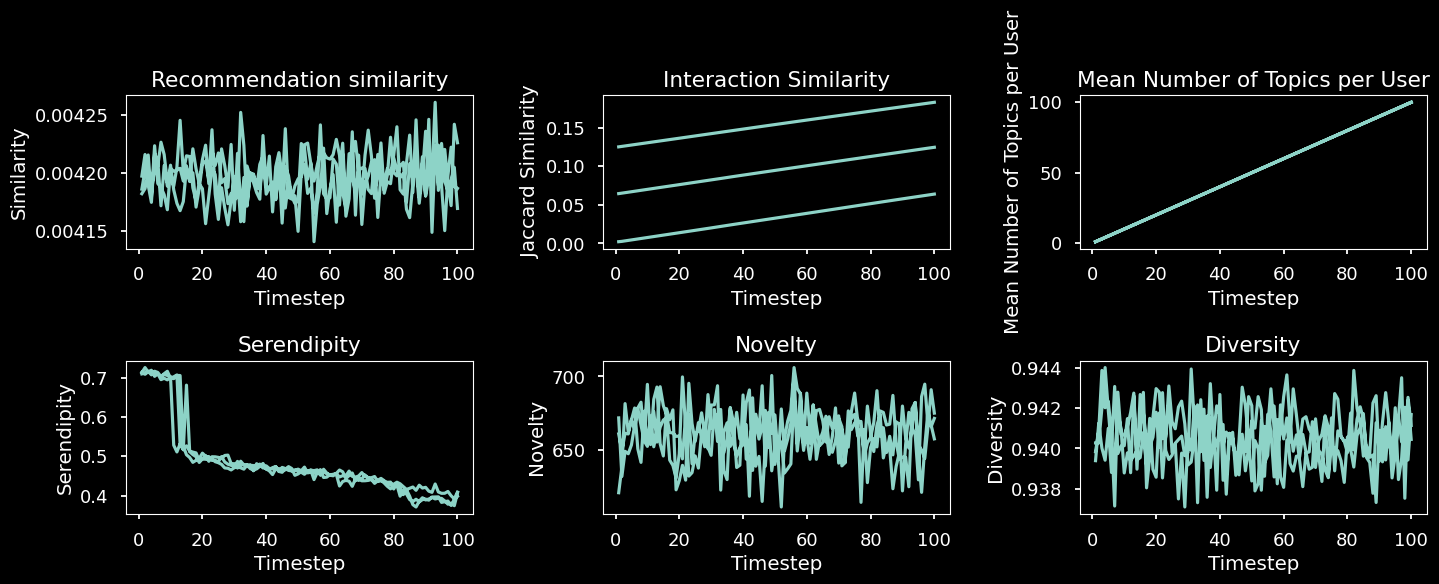

In [85]:
plot_measurements(df)

### Analysis

In [24]:
# print majority / minority outcome stats
def majority_minority_outcomes(metric, split_index):
    split_indices = [split_index]

        
    maj_mean = metric.last_observation[:split_index].mean()
    maj_std = metric.last_observation[:split_index].std()

    min_mean = metric.last_observation[split_index:].mean()
    min_std = metric.last_observation[split_index:].std()

    print("Majority group statistics: ", maj_mean, "(mean), ", maj_std, "(std)")
    print("Minority group statistics: ", min_mean, "(mean), ", min_std, "(std)")
    print()
    
    metric.hist(split_indices)

In [25]:
majority_minority_outcomes(mse, )

NameError: name 'mse' is not defined